# Calculate differential photometry for a variable star, perform low-order polynomial line fitting, and determine distance to M101.

## Imports --ONE IMPORTANT THING TO INSTALL BEFORE RUNNING

This notebook uses a package called `glowing-waffles` in very early stages of development. It is not currently included in the ast366 environment. To install it, open a terminal like usual, activate the ast366 environment, then type: 

`pip install --no-deps glowing-waffles`

In [1]:
from __future__ import print_function, division

%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np

from ccdproc import CCDData
from astropy.visualization import scale_image
from astropy.time import Time

from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

from astropy.table import Table, Column

from glowing_waffles.io import parse_aij_table



# User Configurable Parameters 1

# Modify values in the cell below when you use this for your project

There are a few things you need in the same directory as the notebook for it to work:

+ A reduced image in FITS format.
+ A measurement table saved from AstroImageJ
+ The name of your object.
+ Location of the observatory (needed for heliocentric corrections).
+ A list of which stars are AAVSO comparison stars.
+ A list of the AAVSO comparison magnitudes in the same filter as your measurements.

You can *most* of those things in the cell below, except the comparison star information. That is set a couple of cells below.

In [2]:
aij_data_file = 'MeasurementsR_all.csv'
sample_image = 'm101-004Lt_R.fit'
object_name = 'sn 2011fe'

observatory_latitude = "46.86678d"  # d means degrees
observatory_longitude = "263.54672d"
observatory_altitude = 311  # in meters

## Load measurements and sample image

In [3]:
my_raw_data = parse_aij_table(aij_data_file)

In [4]:
sample_image = CCDData.read(sample_image)
scaled_image = scale_image(sample_image.data, min_percent=20, max_percent=99.5)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


        Use `~astropy.visualization.mpl_normalize.simple_norm` instead. [__main__]


## Show image, overlay star numbers

<IPython.core.display.Javascript object>


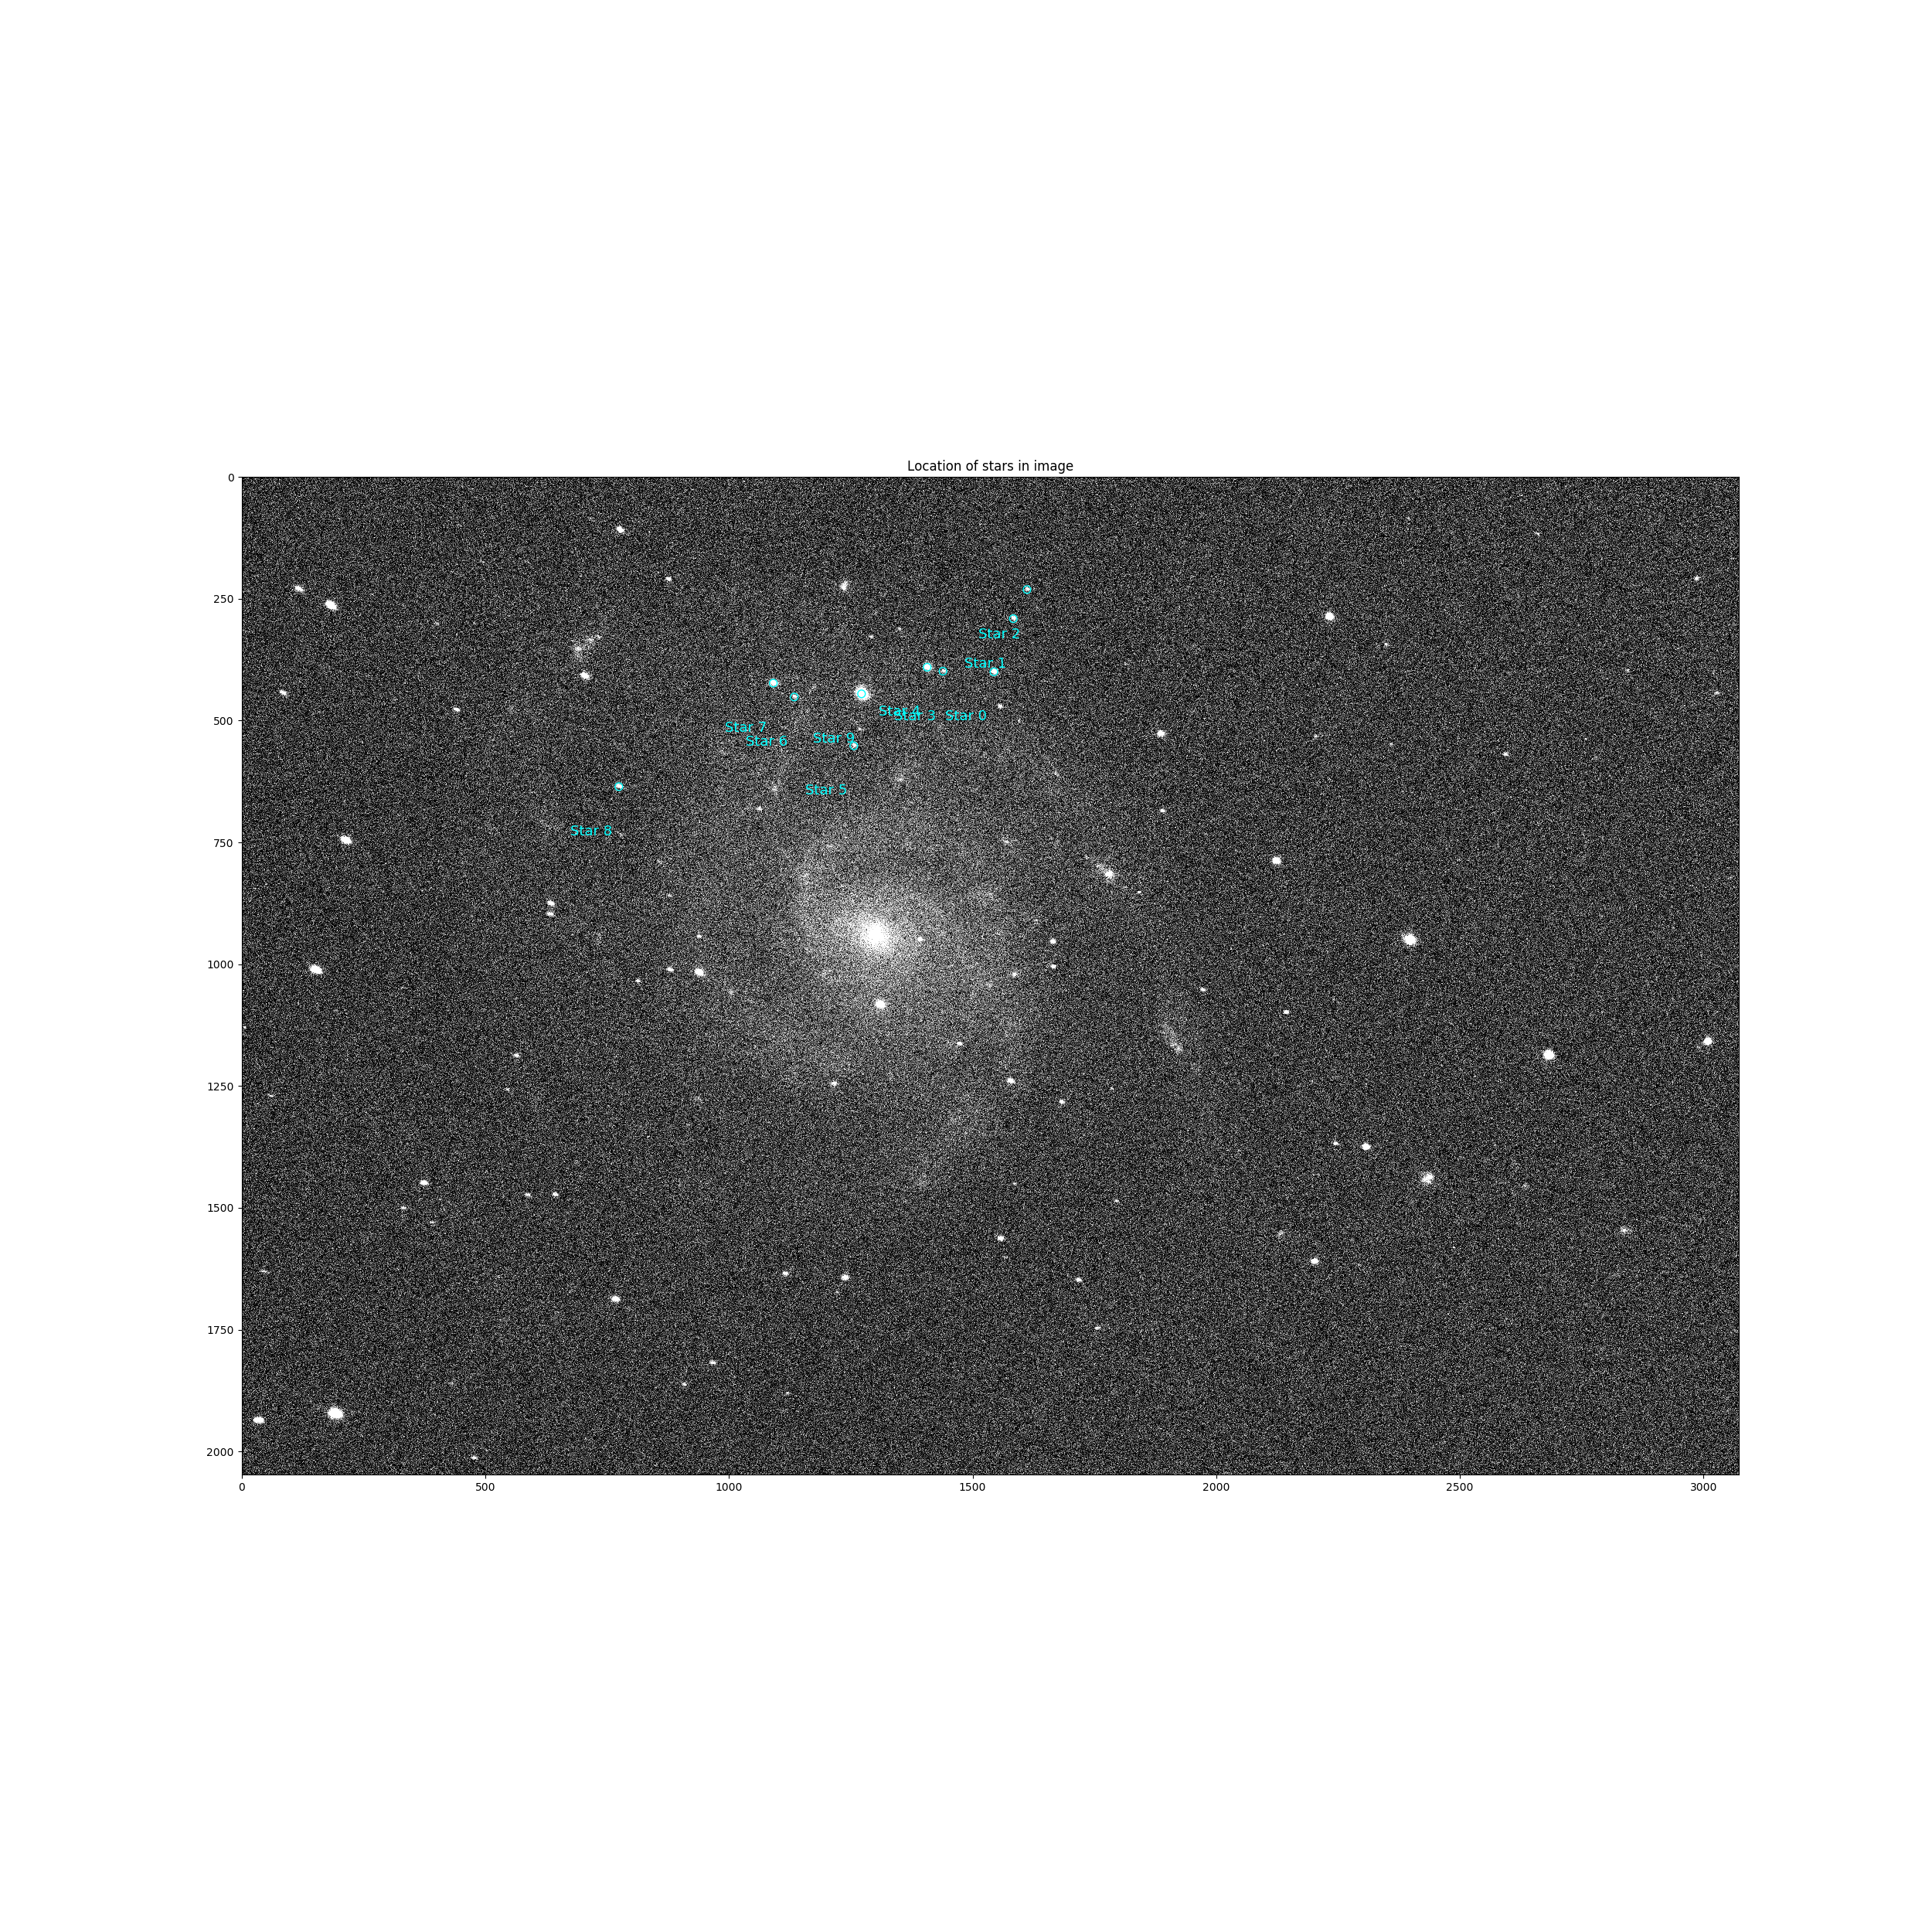

In [5]:
plt.figure(figsize=(25, 25))
plt.imshow(scaled_image, cmap='gray')
for i, star in enumerate(my_raw_data):
    xy_location = sample_image.wcs.all_world2pix((star.ra.mean()), (star.dec.mean()), 0)
    x, y = xy_location
    plt.scatter(x, y, edgecolors='cyan', c='none', s=50)
    plt.text(x - 100, y + 100, 'Star {}'.format(i), fontsize=13, color='cyan')
plt.title('Location of stars in image')

# User Configurable Parameters 2

## Indicate which star is the "target" star

In this case, it is EY UMa, which is star 0.

## Set the list of comparison stars 

Look at the list of comparisons from the AAVSO and list their numbers in the cell below. In this example, the identification is:

+ Star 1 is AAVSO's star 130
+ Star 2 is AAVSO's star 146
+ Star 3 is AAVSO's star 114

### Make absolutely sure you are selecting the correct filter for the magnitudes and list them

List the magnitudes of those comparison stars.

In [6]:
target_star = 9

comparison_stars = [4,7]
comparison_aavso_magnitude = np.array([13.319,13.653])
comparison_aavso_magnitude_errors = np.array([0.008,0.010])


#keeper_idx = [3, 6]
#comparison_stars = comparison_stars[keeper_idx]
#comparison_aavso_magnitude = comparison_aavso_magnitude[keeper_idx]
#comparison_aavso_magnitude_errors = comparison_aavso_magnitude_errors[keeper_idx]

## Define location and object

In [7]:
feder = EarthLocation.from_geodetic(observatory_longitude, 
                                    observatory_latitude, 
                                    height=observatory_altitude)

In [8]:
my_object = SkyCoord.from_name(object_name)

# Calculate comparison magnitudes

In [9]:
s = np.zeros_like(my_raw_data[target_star].magnitude)
n = np.zeros_like(my_raw_data[target_star].magnitude)
weights = np.zeros_like(s)
for comp_star, comp_calib in zip(comparison_stars, comparison_aavso_magnitude):
    #print( my_raw_data[comp_star].magnitude_error[0])
    n += comp_calib/ my_raw_data[comp_star].magnitude_error ** 2
    s += my_raw_data[comp_star].magnitude / my_raw_data[comp_star].magnitude_error ** 2
    weights += 1/my_raw_data[comp_star].magnitude_error ** 2

comparison_average = s / weights
comparison_error = 1 / np.sqrt(weights)

m_comp_calib = n / weights
m_comp_calib_error = 1 / np.sqrt(weights)

#list_of_stars

n = np.zeros_like(my_raw_data[target_star].magnitude)
weights_calib = np.zeros_like(n)
for comp_calib, errors in zip(comparison_aavso_magnitude,comparison_aavso_magnitude_errors):
    n += comp_calib/ errors ** 2
    weights_calib += 1 / errors ** 2
    
#m_comp_calib = n / weights_calib
m_comp_calib_error = 1 / np.sqrt(weights_calib)

# Calculate errors, times, and transform zero point

In [10]:
my_errors = np.sqrt(my_raw_data[target_star].magnitude_error ** 2 + comparison_error ** 2)
time = my_raw_data[target_star].jd_utc_start + my_raw_data[target_star].exposure/86400

brightest_comp = comparison_aavso_magnitude.argmin()
brightest_star_num = comparison_stars[brightest_comp]

zero_point = m_comp_calib
M_calib = my_raw_data[target_star].magnitude - comparison_average + zero_point
M_calib_error = np.sqrt((my_raw_data[target_star].magnitude_error)**2 + (comparison_error)**2 + (m_comp_calib_error)**2)

## Calculate HJD at observatory times

In [11]:
time_apy = Time(time, format='jd')
delta_hjd = time_apy.light_travel_time(my_object, 'heliocentric', location=feder)
time_hjd = time_apy + delta_hjd

## Calculate time of next expected maximum after start of observations

In [12]:
epoch = Time(2454945.713, format='jd')
period = 0.54909 * u.day


In [13]:
prior_epochs = int((Time(time[target_star], format='jd') - epoch)/period)
this_max = epoch + (prior_epochs + 1) * period

In [14]:
data = 'Measurements_from_paper.csv'
paper_data = Table.read(data)

## Plot the data

<IPython.core.display.Javascript object>


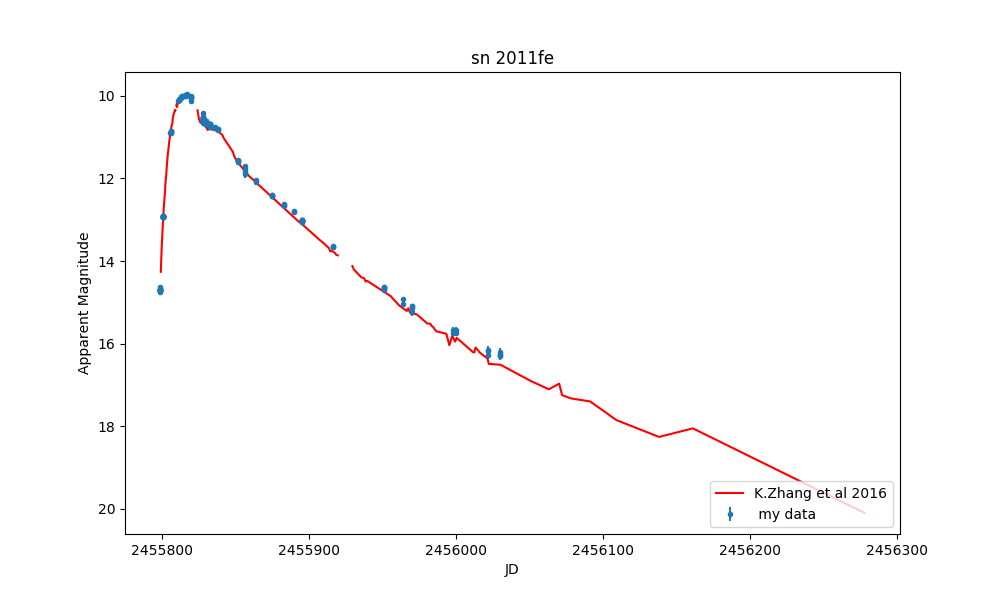

In [15]:
plt.figure(figsize=[10,6])
plt.errorbar(time_hjd.value, 
             my_raw_data[target_star].magnitude - comparison_average + zero_point, 
             yerr=my_errors, fmt='.',
            label=' my data')

plt.plot(paper_data['JD']+2450000.5,paper_data['R'],label = 'K.Zhang et al 2016', color = 'R')

#plt.plot([this_max.value, this_max.value], plt.ylim(),
#        label='Expected time of maximum')
# Reverse the y limits so that brighter is on top
plt.ylim(reversed(plt.ylim()))
#plt.xlim(2455850,2455880)
plt.legend(loc='lower right')
plt.xlabel('JD')
plt.ylabel('Apparent Magnitude')
plt.title(object_name)


In [16]:
#Lets make a table containing all our data

JD = time_hjd.value
Mag = my_raw_data[target_star].magnitude - comparison_average + zero_point
Night = np.array(np.floor(np.array(JD + 0.5)) -1)

newtable = Table([JD, Mag, Night], names = ['JD','Magnitudes','Nights'])
print(newtable)

      JD        Magnitudes    Nights 
------------- ------------- ---------
2455798.62523 14.7042484984 2455798.0
2455798.62677   14.70738677 2455798.0
2455798.62832 14.6970391414 2455798.0
2455798.62986 14.6676223423 2455798.0
2455798.63141  14.682075265 2455798.0
2455798.63382 14.6308842614 2455798.0
2455798.63537 14.7066800183 2455798.0
2455798.63691  14.749098286 2455798.0
2455798.63846 14.7346816694 2455798.0
   2455798.64 14.6951366775 2455798.0
          ...           ...       ...
2455997.71731 15.6658598807 2455997.0
2455997.71966 15.7366868581 2455997.0
2455999.93448 15.6660632837 2455999.0
2455999.95117 15.7352974543 2455999.0
 2456021.8039 16.1778089426 2456021.0
2456021.80701 16.2702763037 2456021.0
2456021.81013  16.154812572 2456021.0
 2456029.7259 16.2580085518 2456029.0
2456029.72746 16.2870247771 2456029.0
2456029.74209 16.1923861795 2456029.0
2456029.74364 16.2723876167 2456029.0
Length = 166 rows


In [17]:
#Now we want to do the binning by grouping

data_grouped = newtable.group_by(Night)
data_binned = data_grouped.groups.aggregate(np.mean)


In [18]:
#We need to include error bars on our data

data_binned_errors = data_grouped.groups.aggregate(np.std)
y_error = (data_binned_errors['JD'])
x_error = (data_binned_errors['Magnitudes'])

#print(binned_error)

<IPython.core.display.Javascript object>


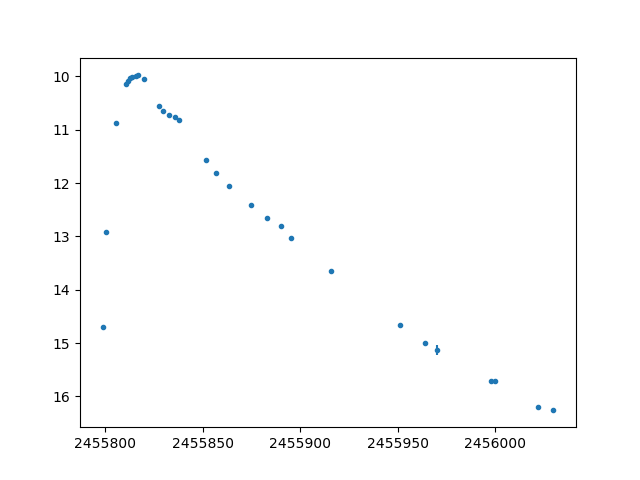

(16.5754495951516, 9.64836647886845)

In [19]:
plt.figure()
plt.errorbar(data_binned['JD'],data_binned['Magnitudes'],yerr=y_error,xerr=x_error,fmt= '.')

plt.ylim(reversed(plt.ylim()))

In [20]:
#We need to define our x and y values from our graph

x = data_binned['JD']
y = data_binned['Magnitudes']

In [21]:
#Need to select range we want to fit a line to along the decline of curve

range_we_want = (x > 2455850) & (x < 2455875)


In [22]:
#Now lets define the fit

the_fit = np.polyfit(x[range_we_want],
                     y[range_we_want],
                     1)

In [23]:
the_fit

array([  3.53383965e-02,  -8.67742501e+04])

In [24]:
fit_polynomial = np.poly1d(the_fit)

In [25]:
y_fit = fit_polynomial(x[range_we_want])

<IPython.core.display.Javascript object>


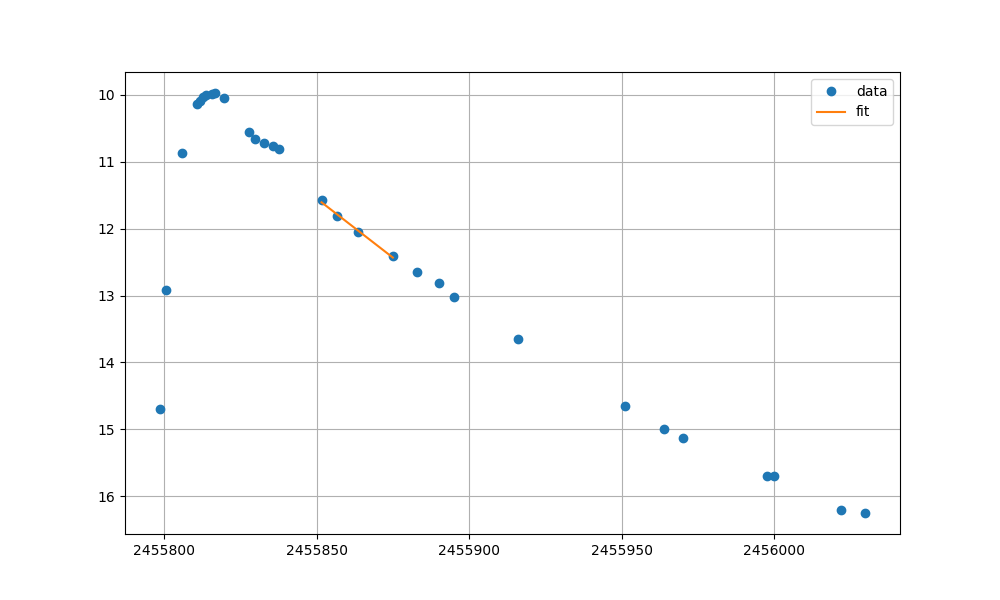

(16.566521318715061, 9.6569914949807796)

In [26]:
plt.figure(figsize=[10,6])
plt.plot(x,y, 'o', label='data')
plt.plot(x[range_we_want], (y_fit), label='fit')
plt.plot
plt.grid()
plt.legend()
plt.ylim(reversed(plt.ylim()))


In [27]:
#We can determine the decline rate magnitude

fifteen_days_later = fit_polynomial(2455829.8964632)

#this gives the magnitude 15 days after maximum

In [28]:
#Now we want to fit another curve to find the maximum magnitude

range_for_maximum = (x > 2455810) & (x < 2455820) 

In [29]:
#fit for maximum 

maximum_fit, covariance_max = np.polyfit(x[range_for_maximum] - 2455815,
                     y[range_for_maximum],
                     2, cov=True)

In [30]:
maximum_fit

array([  5.17829583e-03,  -1.18353900e-02,   9.98520852e+00])

In [31]:
fit_polynomial_for_max = np.poly1d(maximum_fit)
print(fit_polynomial_for_max)

          2
0.005178 x - 0.01184 x + 9.985


In [32]:
[np.sqrt(covariance_max[i, i]) for i in range(3)]

[0.00063426170848509839, 0.0017290427414354281, 0.0077300088501613406]

In [33]:
y_fit_for_max = fit_polynomial_for_max(x[range_for_maximum] -2455815)

<IPython.core.display.Javascript object>


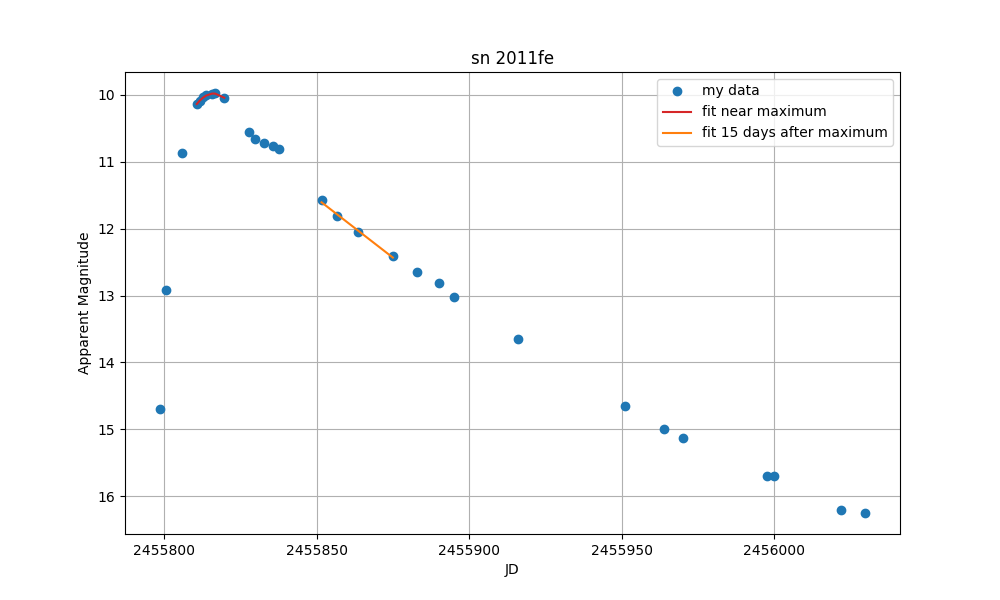

(16.566521318715061, 9.6569914949807796)

In [34]:
plt.figure(figsize=[10,6])
plt.plot(x,y, 'o', label='my data')
plt.plot(x[range_for_maximum], y_fit_for_max, label='fit near maximum', color = 'C3')
plt.plot(x[range_we_want], (y_fit), label='fit 15 days after maximum', color = 'C1')
plt.plot
plt.grid()
plt.legend()
plt.xlabel('JD')
plt.ylabel('Apparent Magnitude')
plt.title('sn 2011fe')
plt.ylim(reversed(plt.ylim()))


In [35]:
#this gives time of maximum of data
max_deriv = fit_polynomial_for_max.deriv()
max_deriv.roots

array([ 1.14278813])

In [36]:
#Now we can find our maximum brightness value
time_max = max_deriv.roots
maximum_magnitude = fit_polynomial_for_max(time_max)
print(maximum_magnitude)

[ 9.97844585]


In [37]:
covariance_max

array([[  4.02287915e-07,  -5.04911895e-08,  -3.64270885e-06],
       [ -5.04911895e-08,   2.98958880e-06,   2.40843616e-06],
       [ -3.64270885e-06,   2.40843616e-06,   5.97530368e-05]])

In [50]:
#Uncertainty in the peak magnitude
n = 2
TT = np.vstack([time_max**(n-i) for i in range(n+1)]).T
C_yi = np.dot(TT, np.dot(covariance_max, TT.T))
sig_yi = np.sqrt(np.diag(C_yi))
sig_yi

#Uncertainty in the magnitude 15 days later 0.022

#Now to find the decline rate uncerainty, we add the peak mag and 15 days mag error in quadrature

decline_rate_error = np.sqrt((sig_yi)**2 + (0.022)**2)
print(decline_rate_error)
print(sig_yi, "error in the peak magnitude")

[ 0.02332773]
[ 0.00775776] error in the peak magnitude


#We need to calculate the error in our maximum apparent magnitude value
error_in_max = np.sqrt((3.9985066590977247e-07*time_max**2)**2 + (1.9639215748406247*time_max)**2 + ( 2411585.9934603181)**2)
print(error_in_max)

In [42]:
#Want to find derivative

np.polyder(fit_polynomial_for_max) 

poly1d([ 0.01035659, -0.01183539])

In [43]:
#Now we want to calculate the absolute magnitudes

a = -19.251
b = 0.522
decline_rate = fifteen_days_later - maximum_magnitude

M_b = a + (b*(decline_rate - 1.1))

#The uncertainity of the absolute magnitude is b times the error in the decline rate
Uncertainty_in_Mb = b * decline_rate_error

print(M_b, 'Absolute Magnitude')
print(decline_rate, "decline rate")
print(Uncertainty_in_Mb, 'error in absolute magnitude in B filter')

[-19.3751372] Absolute Magnitude
[ 0.86218928] decline rate
0.0367379457256 error in absolute magnitude in B filter


In [44]:
#The distance modulus is then

dist_modulus = maximum_magnitude - M_b
print(dist_modulus, 'distance modulus')

[ 29.35358304] distance modulus


In [46]:
#Now, using the distance modulus, we can calculate the distance to the galaxy

distance = np.exp(((5*np.log(10)) + (dist_modulus*np.log(10)))/5)
print(distance/1000000, 'megaparsecs')

[ 7.42534452] megaparsecs
